In [1]:
import numpy as np
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import h5py 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import segmentation_models as sm
import tensorflow.keras
# from tensorflow import keras
# from tensorflow.keras.layers import Input

Segmentation Models: using `keras` framework.


In [2]:
# 读取训练集
fh5 = h5py.File(r'E:\wujieyu\img train PolypGen+CVC\img\PolypGen+CVCtrain_imgandmasks.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_x = fh5['img']
img_png_x = np.array(img_png_x)
#img_gray_c = fh5['img_gray']
#img_gray_c = np.array(img_gray_c)
mask_x = fh5['masks']
mask_x = np.array(mask_x)

In [3]:
img_png_x.shape

(2987, 288, 384, 3)

In [4]:
img_png_x.max()

1.0

In [5]:
# 归一化操作
imgmax = img_png_x.max()

In [6]:
imgmax

1.0

In [7]:
img_png_x = img_png_x/(imgmax)

In [8]:
#查看是否归一化
img_png_x.max()

1.0

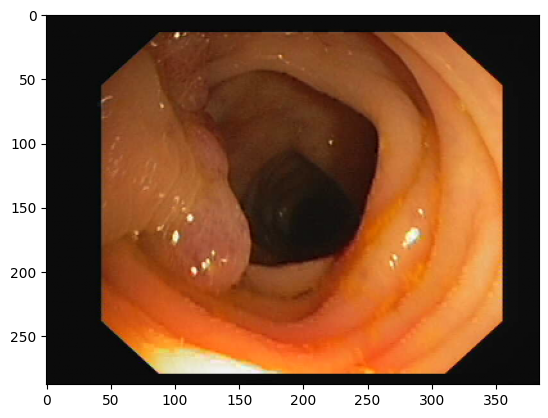

In [9]:
plt.imshow(img_png_x[10])

In [10]:
mask_x.max()

255.0

In [11]:
mask_x  = mask_x .reshape(len(mask_x),288, 384, 1)
mask_x .shape

(2987, 288, 384, 1)

In [12]:
mask_x = mask_x/255

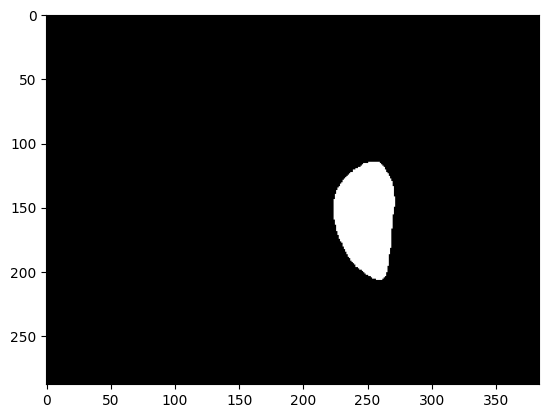

In [13]:
plt.imshow(mask_x[199],'gray')

In [14]:
#查看是否归一化
mask_x.max()

1.0

In [15]:
# mask_x[0]

In [16]:
# 划分训练集与验证集
# 划分训练集与验证集
# 划分训练集与验证集
# T_img_png_x
# T_mask_x
# V_img
# V_mask

In [17]:
# -----------------------------------------------------------------
# 从txt文件读取并恢复为NumPy数组
# -----------------------------------------------------------------
# 读取训练集
# Train = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Train.txt', dtype=int)
Train = np.loadtxt('D:\edge\Train.txt', dtype=int)
# 读取验证集
# Val = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Val.txt', dtype=int)
Val = np.loadtxt('D:\edge\Val.txt', dtype=int)

In [18]:
Train.shape

(2390,)

In [19]:
Val.shape

(597,)

In [20]:
# -----------------------------------------------------------------
# 按索引划分图像数据
# -----------------------------------------------------------------
# 划分训练集（T_img_png_x）和验证集（V_img）
T_img = img_png_x[Train]
V_img = img_png_x[Val]

In [21]:
T_img.shape

(2390, 288, 384, 3)

In [22]:
V_img.shape

(597, 288, 384, 3)

In [23]:
T_mask = mask_x[Train]
V_mask = mask_x[Val]

In [24]:
T_mask.shape

(2390, 288, 384, 1)

In [25]:
V_mask.shape

(597, 288, 384, 1)

(-0.5, 383.5, 287.5, -0.5)

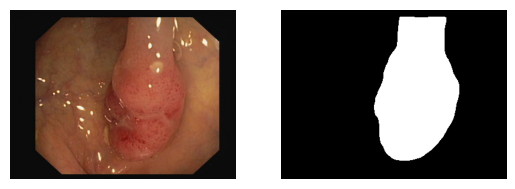

In [26]:
# 查看训练集集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(T_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(T_mask[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

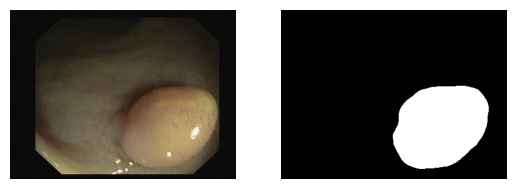

In [27]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(V_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(V_mask[a],'gray')
plt.axis('off')

In [2]:
BACKBONE = 'inceptionv3'##骨架

In [3]:
# model = sm.Unet(BACKBONE) #模型
import segmentation_models as sm
sm.set_framework('tf.keras')
model = sm.Unet(BACKBONE)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [31]:
# from tensorflow.keras.utils import plot_model     ##模型结构图
# plot_model(model, 'D:\\projiect\\data\\CVC\\model_3d.png')

In [32]:
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [33]:
import keras
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(  monitor='val_iou_score',  # 监控指标（默认：val_loss）
                                        factor=0.5,               # 学习率衰减系数（新学习率 = 旧学习率 * factor）
                                        patience=20,              # 等待 epoch 数无改善后触发
                                        mode='max'              # 监控指标方向：'auto'/'min'/'max'（自动检测最大/最小化）
                                        # min_delta=0.0001,         # 视为“改善”的最小变化阈值
                                        # cooldown=0,               # 触发后暂停监控的 epoch 数（防止频繁调整）
                                        # min_lr=0                  # 学习率下限（避免过小导致训练停滞）
                                     ),

    
    keras.callbacks.ModelCheckpoint(filepath=r'E:\wujieyu\IoU best\U-net+V3\1 img1\img_bestweigh_epoch_{epoch:03d}_val_iou_{val_iou_score:.4f}.h5', 
                                    # 保存路径（支持 epoch 变量，如 model_{epoch:02d}.h5）
                                    monitor='val_iou_score',
                                    save_best_only=True,           # 只保留最优模型
                                    save_weights_only=True,       # 若为 True 只保存权重，否则保存完整模型
                                    mode='max'                   # 监控指标方向（与 ReduceLROnPlateau 相同）
                                   )   ##保存最佳模型
                                      
    #keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', 
                                  #baseline=None, restore_best_weights=False)
    ]

In [34]:
# model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
#     filepath=r'D:\projiect_data\weight\img\img_bestweigh.h5',
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='auto')

In [35]:
V_mask.shape

(597, 288, 384, 1)

In [36]:

# 模型训练
model.fit(
       x=T_img,
       y=T_mask,
       # validation_split=0.2,  # 验证集
       batch_size=4,
       epochs=300,
       validation_data=(V_img, V_mask),
       callbacks = callbacks_list
)

Epoch 1/300
598/598 [==============================] - 51s 71ms/step - loss: 0.8460 - iou_score: 0.3909 - val_loss: 0.9068 - val_iou_score: 0.4361 - lr: 0.0010
Epoch 2/300
598/598 [==============================] - 39s 65ms/step - loss: 0.6833 - iou_score: 0.5137 - val_loss: 0.8847 - val_iou_score: 0.4185 - lr: 0.0010
Epoch 3/300
598/598 [==============================] - 40s 67ms/step - loss: 0.6109 - iou_score: 0.5663 - val_loss: 0.7059 - val_iou_score: 0.4839 - lr: 0.0010
Epoch 4/300
598/598 [==============================] - 41s 69ms/step - loss: 0.5796 - iou_score: 0.5908 - val_loss: 0.5865 - val_iou_score: 0.5769 - lr: 0.0010
Epoch 5/300
598/598 [==============================] - 41s 69ms/step - loss: 0.5352 - iou_score: 0.6199 - val_loss: 0.5772 - val_iou_score: 0.5968 - lr: 0.0010
Epoch 6/300
598/598 [==============================] - 41s 68ms/step - loss: 0.4971 - iou_score: 0.6484 - val_loss: 0.4910 - val_iou_score: 0.6293 - lr: 0.0010
Epoch 7/300
598/598 [===================

KeyboardInterrupt: 

In [36]:
model.save_weights(r'E:\wujieyu\IoU best\img Highlights_processing\img Highlights_processing_FMM_statistical\300img_Highlights_processing_FMM_statistical_weigh.h5')
# #路径文件名

In [5]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\images\test_CVC-ColonDB_imgandmasks.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c = fh5['img']
img_png_c = np.array(img_png_c)
mask_c = fh5['masks']
mask_c = np.array(mask_c)

In [6]:
img_png_c.max()

1.0

In [7]:
mask_c.max()

255.0

In [8]:
mask_c=mask_c/255

In [9]:
mask_c.max()

1.0

In [10]:
# 读取测试集
fh5 = h5py.File(r'E:\wujieyu\img test\TestDataset\CVC-ColonDB\img Highlights processing FMM\test_CVC-ColonDB_imgandmasks_Highlights_percentile=99.5.h5','r')
#fh5 = h5py.File(r'D:\PolypGen+CVCtrain_imgandmasks.h5','r')
img_png_c1 = fh5['img']
img_png_c1 = np.array(img_png_c1)
mask_c1 = fh5['masks']
mask_c1 = np.array(mask_c1)

In [11]:
img_png_c1.max()

1.0

In [12]:
mask_c1.max()

1.0

(-0.5, 383.5, 287.5, -0.5)

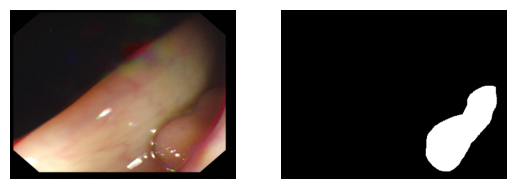

In [13]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

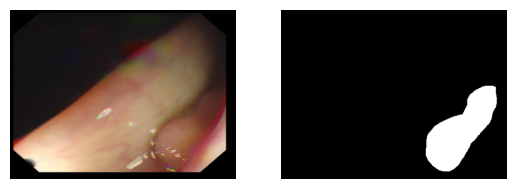

In [14]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c1[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c1[a],'gray')
plt.axis('off')

In [19]:
import tensorflow as tf

def bce_jaccard_loss(y_true, y_pred, smooth=1e-7, alpha=0.5):
    """
    参数说明：
    - y_true: 真实标签 (shape=[batch, H, W, 1])
    - y_pred: 模型预测值 (shape=[batch, H, W, 1])
    - smooth: 防止除零的小常数
    - alpha: 平衡 BCE 和 Jaccard 的权重（默认 0.5）
    """
    # 计算二元交叉熵
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # 计算 Jaccard Loss (IoU Loss)  
    y_true_f = tf.keras.backend.flatten(y_true)   # 展平为向量 [batch*H*W]
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard  # 将 IoU 转换为 Loss
    
    # 加权组合
    return alpha * bce + (1 - alpha) * jaccard_loss

In [20]:
def dice_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * intersection + smooth) / (denominator + smooth)

In [21]:
# def iou_score(y_true, y_pred, smooth=1e-7):
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
#     return (intersection + smooth) / (union + smooth)

In [22]:
model.compile(
    optimizer='Adam',
    loss=bce_jaccard_loss,  # 可替换为 iou_loss 或 bce_jaccard_loss
    metrics=[
        dice_score, 
        sm.metrics.iou_score
        # tf.keras.metrics.BinaryAccuracy()  # 可选：添加准确率指标
    ]
)

In [23]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\U-net+V3\1 img\img_bestweigh_epoch_114_val_iou_0.7925.h5', by_name=True)

In [24]:
# 评估模型（返回 loss + metrics）
results = model.evaluate(img_png_c, mask_c, verbose=0)

In [25]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results[0]:.4f}")
print(f"dice_score: {results[1]:.4f}")
print(f"iou_score: {results[2]:.4f}")


=== 测试结果 ===
Loss: 0.4139
dice_score: 0.7373
iou_score: 0.6273


In [26]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\U-net+V3\2 img Highlights_processing\img Highlights_processing_FMM_percentile=99.5\img_Highlights_percentile=99.5_bestweigh_epoch_102_val_iou_0.7815.h5', by_name=True)

In [27]:
# 新方法评估模型（返回 loss + metrics）
results1 = model.evaluate(img_png_c1, mask_c1, verbose=0)

In [28]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results1[0]:.4f}")
print(f"dice_score: {results1[1]:.4f}")
print(f"iou_score: {results1[2]:.4f}")


=== 测试结果 ===
Loss: 0.3769
dice_score: 0.7646
iou_score: 0.6569


In [15]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\U-net+V3\1 img\img_bestweigh_epoch_114_val_iou_0.7925.h5', by_name=True)

In [16]:
#测试mask
imgp = model.predict(img_png_c, verbose=1)

12/12 [==============================] - 7s 231ms/step


In [17]:
# # 加载模型
model.load_weights(r'E:\wujieyu\IoU best\U-net+V3\2 img Highlights_processing\img Highlights_processing_FMM_percentile=99.5\img_Highlights_percentile=99.5_bestweigh_epoch_102_val_iou_0.7815.h5', by_name=True)

In [18]:
#测试mask
imgp1 = model.predict(img_png_c1, verbose=1)

12/12 [==============================] - 1s 77ms/step


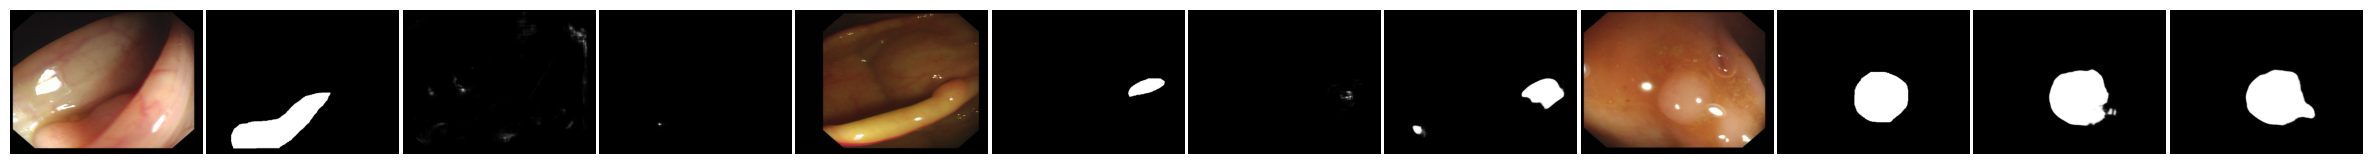

In [20]:
a, b, c = 8, 117, 311

# 设置更大的画布和紧凑布局
plt.figure(figsize=(24, 6))  # 宽度增加，高度适当调整
plt.subplots_adjust(wspace=0.02, 
                    left=0.01, 
                    right=0.99, 
                    top=0.5, 
                    bottom=0.05)  # 调整左右边距和子图间距

# 第1组子图
plt.subplot(1,12,1)
plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(1,12,2)
plt.imshow(mask_c[a], 'gray')
plt.axis('off')
plt.subplot(1,12,3)
plt.imshow(imgp[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,4)
plt.imshow(imgp1[a].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第2组子图
plt.subplot(1,12,5)
plt.imshow(img_png_c[b])
plt.axis('off')
plt.subplot(1,12,6)
plt.imshow(mask_c[b], 'gray')
plt.axis('off')
plt.subplot(1,12,7)
plt.imshow(imgp[b].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,8)
plt.imshow(imgp1[b].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第3组子图
plt.subplot(1,12,9)
plt.imshow(img_png_c[c])
plt.axis('off')
plt.subplot(1,12,10)
plt.imshow(mask_c[c], 'gray')
plt.axis('off')
plt.subplot(1,12,11)
plt.imshow(imgp[c].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,12)
plt.imshow(imgp1[c].reshape(288, 384), cmap='gray')
plt.axis('off')

plt.show()

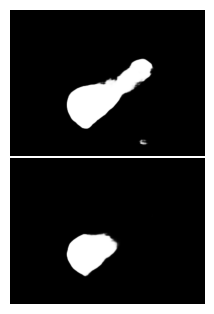

In [31]:
a = 4
# 创建紧凑画布
fig = plt.figure(figsize=(6, 3))

# 使用GridSpec控制微小边距
gs = fig.add_gridspec(2, 1, 
                     hspace=0.02,  # 行间距
                     left=0.01,    # 左边距
                     right=0.99,   # 右边距
                     top=0.99,     # 上边距
                     bottom=0.01)  # 下边距

# 添加图像子图
ax1 = fig.add_subplot(gs[0])
ax1.imshow(imgp[a].reshape(288, 384), 'gray')
ax1.axis('off')
ax1.margins(0.01)  # 图像周围微小边距

ax2 = fig.add_subplot(gs[1])
ax2.imshow(imgp1[a].reshape(288, 384), 'gray')
ax2.axis('off')
ax2.margins(0.01)  # 图像周围微小边距

# 显示紧凑布局
plt.show()